In [0]:
import numpy as np
from google.colab import drive
import os
import sys

In [0]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# RNN Layer

$$h_t = tanh(h_{t-1}W_h + x_tW_t + b)$$

## Single RNN Cell

In [0]:
class RNN:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None
  
  def forward(self, x, h_prev):
    Wx, Wh, b = self.params
    t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
    h_next = np.tanh(t)
    
    self.cache = (x, h_prev, h_next)
    return h_next
  
  def backward(self, dh_next):
    Wx, Wh, b = self.params
    x, h_prev, h_next = self.cache
    
    dt = dh_next * (1 - h_next ** 2)
    db = np.sum(dt, axis=0)
    dWh = np.dot(h_prev.T, dt)
    dh_prev = np.dot(dt, Wh.T)
    dWx = np.dot(x.T, dt)
    dx = np.dot(dt, Wx.T)
    
    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db
    
    return dx, dh_prev

## Time RNN

In [0]:
class TimeRNN:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = None
    
    self.h, self.dh = None, None
    self.stateful = stateful
  
  def set_state(self, h):
    self.h = h
  
  def reset_state(self):
    self.h = None
    
  def forward(self, xs):
    Wx, Wh, b = self.params
    
    # N: batch size, T: time series, D: data dimensions
    N, T, D = xs.shape
    
    # H: hidden state size
    D, H = Wx.shape
    
    self.layers = []
    hs = np.empty((N, T, D), dtype='f')
    
    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype='f')
      
    # generate RNN cells
    for t in range(T):
      layer = RNN(*self.params)
      self.h = layer.forward(xs[:,t,:], self.h)
      hs[:,t,:] = self.h
      self.layers.append(layer)
      
    return hs
  
  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, D = dhs.shape
    D, H = Wx.shape
    
    # pass to the upstreaming layer in BPTT
    dxs = np.empty((N, T, D), dtype='f')
    dh = 0
    grads = [0, 0, 0]
    
    for t in reversed(range(T)):
      layer = self.layers[t]
      dx, dh = layer.backward(dhs[:, t, :] + dh)
      dxs[:, t, :] = dx
      
      for i, grad in enumerate(layer.grads):
        grads[i] += grad
        
    for i, grad in enumerate(grads):
      self.grads[i][...] = grad
    self.dh = dh
    
    return dxs

# RNNLM (RNN Language Model)

In [0]:
%cd /content/gdrive/My\ Drive/deep_learning_from_scratch
!pwd

/content/gdrive/My Drive/deep_learning_from_scratch
/content/gdrive/My Drive/deep_learning_from_scratch


In [0]:
sys.path.append("common")

In [0]:
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 'common']

In [0]:
from time_layers import TimeEmbedding, TimeAffine, TimeSoftmaxWithLoss

In [0]:
class SimpleRnnlm:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn
    
    # initialization weights
    embed_W = (rn(V, D) / 100).astype('f')
    rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
    rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
    rnn_b = np.zeros(H).astype('f')
    affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')
    
    # generate each layers
    self.layers = [
        TimeEmbedding(embed_W),
        TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
        TimeAffine(affine_W, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.rnn_layer = self.layers[1]
    
    # gather all weights and grads
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads
  
  def forward(self, xs, ts):
    for layer in self.layers:
      xs = layer.forward(xs)
    loss = self.loss_layer.forward(xs, ts)
    return loss
  
  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout
  
  def reset_state(self):
    self.rnn_layer.reset_state()

## Training

In [0]:
sys.path.append("dataset")

In [0]:
import ptb
from optimizer import SGD

### hyperparameters

In [0]:
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

### Loading dataset

In [0]:
_corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = _corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
print(vocab_size)

418


In [0]:
xs = corpus[:-1]  # input (data)
ts = corpus[1:]   # output (label)
data_size = len(xs)
print(data_size)

999


### Parameters

In [0]:
max_iters = data_size // (batch_size * time_size)
print("max iters: {}".format(max_iters))
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

max iters: 19


### Generating a Model

In [0]:
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

### Starting Training

In [0]:
# calculate data zone (like sliding window)
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]
print("jump: {}, offsets: {}".format(jump, offsets))

jump: 99, offsets: [0, 99, 198, 297, 396, 495, 594, 693, 792, 891]


In [0]:
for epoch in range(max_epoch):
  for iter in range(max_iters):
    # get batch data
    batch_x = np.empty((batch_size, time_size), dtype='i')
    batch_t = np.empty((batch_size, time_size), dtype='i')
    for t in range(time_size):
      for i, offset in enumerate(offsets):
        batch_x[i, t] = xs[(offset + time_idx) % data_size]
        batch_t[i, t] = ts[(offset + time_idx) % data_size]
      time_idx += 1
      
    # calculate grads and perplexity
    loss = model.forward(batch_x, batch_t)
    model.backward()
    optimizer.update(model.params, model.grads)
    total_loss += loss
    loss_count += 1
  
  # record perplexity
  ppl = np.exp(total_loss / loss_count)
  print("epoch: {}, perplexity: {:.2f}".format(epoch, ppl))
  ppl_list.append(float(ppl))
  total_loss, loss_count = 0, 0

epoch: 0, perplexity: 385.13
epoch: 1, perplexity: 257.91
epoch: 2, perplexity: 225.61
epoch: 3, perplexity: 218.22
epoch: 4, perplexity: 208.18
epoch: 5, perplexity: 203.82
epoch: 6, perplexity: 198.42
epoch: 7, perplexity: 197.05
epoch: 8, perplexity: 191.63
epoch: 9, perplexity: 193.23
epoch: 10, perplexity: 188.56
epoch: 11, perplexity: 192.57
epoch: 12, perplexity: 189.61
epoch: 13, perplexity: 190.22
epoch: 14, perplexity: 189.06
epoch: 15, perplexity: 185.34
epoch: 16, perplexity: 182.27
epoch: 17, perplexity: 179.15
epoch: 18, perplexity: 181.24
epoch: 19, perplexity: 182.40
epoch: 20, perplexity: 180.26
epoch: 21, perplexity: 176.30
epoch: 22, perplexity: 173.21
epoch: 23, perplexity: 176.12
epoch: 24, perplexity: 171.60
epoch: 25, perplexity: 170.55
epoch: 26, perplexity: 165.80
epoch: 27, perplexity: 164.08
epoch: 28, perplexity: 161.95
epoch: 29, perplexity: 155.04
epoch: 30, perplexity: 154.43
epoch: 31, perplexity: 148.16
epoch: 32, perplexity: 151.25
epoch: 33, perplexit

### Results

In [0]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'perplexity')

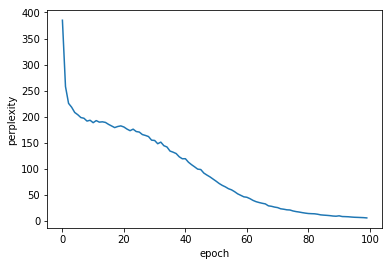

In [0]:
plt.plot(ppl_list)
plt.xlabel("epoch")
plt.ylabel("perplexity")